# Load in packages to run hydromechanical model and plot

In [38]:
# Load in necessary packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as spr
from scipy.sparse.linalg import inv
from pyproj import Proj, transform

In [39]:
# Loading in the interpolated data frame produced in the PreExfiltration.ipynb or PreExfiltrationSpline.ipynb
file_path ='smoothedthicknesstimeseries.csv'
interpolated_df = pd.read_csv(file_path)

# Calculate the duration for each site
duration_tf = interpolated_df.groupby('Site').agg(
    Start_Age=('Age', 'max'),
    End_Age=('Age', 'min'),
    Duration=('Age', lambda x: x.max() - x.min())
).reset_index()

# Display the first few rows of the duration data
duration_tf.head()

,Site,Start_Age,End_Age,Duration
0,1,7577.0,4914.0,2663.0
1,2,9626.0,3769.0,5857.0
2,3,18129.0,3625.0,14504.0
3,4,3932.0,3342.0,590.0
4,5,9047.0,3755.0,5292.0


# Parameters

In [40]:
intSave=100
year = 3600*24*365
#xi is dimensionless loading efficiency(Skempton's constant)
xi = 0.2
#rhoi is the density of glacier ice (kg/m3)
rhoi = 920
#rhow is density of water
rhow = 1000
#g is acceleration due to gravity (m/s2)
g = 9.81
#mu_w is the viscosity of water (Pa*s)
mu_w = 1e-3
#S is sediment specific storage capacity (m-1)
S = 1e-6
#permeability
perm=1e-15
#K_t is the hydraulic conductivity (function of perm which we assume stays constant over time)
K_t = perm*rhow*g/mu_w
#Can't find this in the paper, but assuming it has somthing to do 
D = K_t/S
#H_init is the initial thickness of overlying glacier ice (m)
h_init = 1e3
#dh is height change? also (m)? 
dh=100

# Grids and pre-allocation

In [41]:
# Define the length of the domain (L) in meters. In this case, it's 40 km (40,000 meters).
L = 40e3

# Set the number of grid points (nx) to 1001
nx = int(1e3 + 1) # Make it smaller to make the grid coarser 

# Generate a linearly spaced array (x) from 0 to L, with nx points.
# This array represents the spatial coordinates across the domain.
x = np.linspace(0, L, num=nx)

# Calculate the grid spacing (dx) as the difference between consecutive points in the x array.
dx = x[1] - x[0]

# Set a diffusion coefficient (C_D) to 1, which is a dimensionless parameter used in the time step calculation.
C_D = 1

# Calculate the time step (dt) based on the grid spacing (dx) and a given diffusion constant (D).
# The time step is determined by the stability criterion for the diffusion equation.
dt = (dx**2) * C_D / D # Make the time step longer by changing nx.

# Define the total simulation time (tf) in seconds
tf = (site_data['Age'].max() - site_data['Age'].min()) * year #How many years we want the simulation to be 

# Calculate the total number of time steps (nt) based on the total time (tf) and the time step (dt).
# The result is rounded and then increased by 1 to account for the initial time step.
#nt = int(np.round(tf / dt) + 1)
nt = len(site_data)

# Generate a linearly spaced array (t) from 0 to tf, with nt points.
# This array represents the time steps across the entire simulation period.
#t = np.linspace(0, tf, num=nt) # Vector that goes over the years you want to simulate. 
t = site_data['Age'].values * year 

# Initialize the hydraulic pressure head (h) within the sediment.
# The initial head (h_init) is scaled by the ratio of ice density (rhoi) to water density (rhow)
# and is uniformly applied across the entire domain (nx points).
h = h_init * (rhoi / rhow) * np.ones(nx)

# Create an array (h_all) to store the hydraulic pressure head values at each time step for the entire domain.
# The array has dimensions [nx, int(nt/intSave)+1], where intSave is a variable controlling the frequency of saving data.
h_all = np.zeros([nx, int(nt/intSave) + 1])

# Store the initial hydraulic pressure head (h) in the first column of h_all.
h_all[:, 0] = h


In [64]:
# Set the site number 
site = 18 # Specify the site number
site_data = interpolated_df[interpolated_df['Site'] == site]

# Interpolate thickness data to match the time steps
f_interp = np.interp(t/year, site_data['Age'], site_data['Thickness'])

# Assign interpolated thickness values to hbc_sfc
hbc_sfc[:] = f_interp

# Extract latitude and longitude
site_lat = site_data['Latm'].values[0]  # Latitude of the site
site_lon = site_data['Lonm'].values[0]  # Longitude of the site

# Specify time-dependent load change

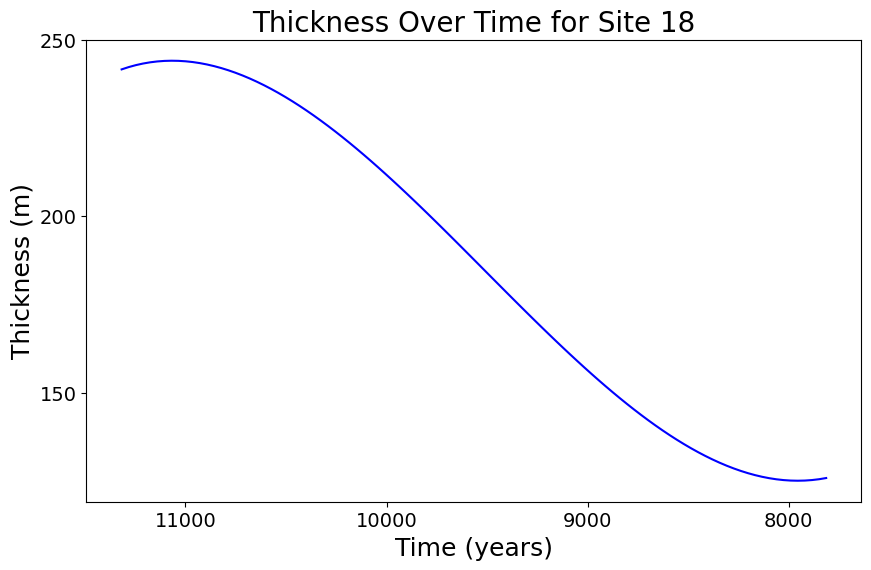

In [65]:
#this is where we'll change the time domain to geologic timescales-so eventually 20,000 years 
#ramp_time = 20 #in years

# Initialize an array to store the ice surface height at different time steps
#hbc_sfc  = np.zeros(int(nt)); #nt is the total number of time steps 
hbc_sfc = site_data['Thickness'].values

#change in ice surface height with time
dhdt = np.zeros_like(hbc_sfc)

# Create boolean masks to identify the time before and after the ramp time
#bramp_bool = t < ramp_time*year #before ramp time
#aramp_bool = t >= ramp_time*year #after ramp time 

# For times before the ramp, linearly decrease the ice surface height from initial height h_init to h_init - dh
#hbc_sfc[bramp_bool] = np.linspace(h_init,h_init-dh,np.count_nonzero(bramp_bool, axis=None))

# For times after the ramp, keep the ice surface height constant at h_init - dh
#hbc_sfc[aramp_bool] = h_init-dh;

# Calculate the rate of change of ice surface height over time by taking the difference between consecutive time steps
dhdt[1:] = np.diff(hbc_sfc)/dt

#Optional: Uncommenting the following lines would instead set dhdt to a linear decrease over the ramp period
#dhdt[bramp_bool] = -np.linspace(0,2*dh/ramp_time,np.count_nonzero(bramp_bool, axis=None))/year
#hbc_sfc = h_init + np.cumsum(dhdt*dt)

plt.figure(figsize=(10, 6))
plt.plot(site_data['Age'], site_data['Thickness'], color='blue')
plt.xlabel('Time (years)', fontsize=18)  # Increase the font size
plt.ylabel('Thickness (m)', fontsize=18)  # Increase the font size
plt.title(f'Thickness Over Time for Site {site}', fontsize=20)  # Increase the font size
plt.gca().invert_xaxis()  # Invert x-axis so that time decreases to the right

# Customize ticks
plt.xticks(fontsize=14)  # Set x-axis tick font size
plt.yticks(fontsize=14)  # Set y-axis tick font size

# Reduce the number of ticks
plt.locator_params(axis='x', nbins=5)  # Fewer ticks on the x-axis
plt.locator_params(axis='y', nbins=5)  # Fewer ticks on the y-axis

plt.show()

# Solve with Crank-Nicolson method

In [66]:
# Initialize a 3x(nx) matrix filled with zeros to store the diagonals for the left-side matrix (Ml)
Mld = np.zeros([3,nx])

# Set the first and third rows of the matrix to be -0.5*C_D for all columns
Mld[0, :] = -0.5 * C_D * np.ones(nx)  # Upper diagonal
Mld[2, :] = -0.5 * C_D * np.ones(nx)  # Lower diagonal

# Set the second row of the matrix to be (1+C_D) for all columns
Mld[1, :] = (1 + C_D) * np.ones(nx)  # Main diagonal

# Create a sparse matrix (Ml) using the diagonals in Mld with offsets -1, 0, and 1
Ml = spr.spdiags(Mld, [-1, 0, 1], nx, nx)

# Convert the sparse matrix to a compressed sparse column format for efficient arithmetic and matrix-vector operations
Ml = spr.csc_matrix(Ml)

# Modify specific elements in the sparse matrix to enforce boundary conditions
Ml[-1, -1] = 1 + 0.5 * C_D  # Adjust the last element on the main diagonal
Ml[0, 1] = 0  # Set the first off-diagonal element to zero
Ml[0, 0] = 1  # Set the first element on the main diagonal to one

# Compute the inverse of the left-side matrix (Ml)
iMl = inv(Ml)

# Initialize a 3x(nx) matrix filled with zeros to store the diagonals for the right-side matrix (Mr)
Mrd = np.zeros([3, nx])

# Set the first and third rows of the matrix to be 0.5*C_D for all columns
Mrd[0, :] = 0.5 * C_D * np.ones(nx)  # Upper diagonal
Mrd[2, :] = 0.5 * C_D * np.ones(nx)  # Lower diagonal

# Set the second row of the matrix to be (1-C_D) for all columns
Mrd[1, :] = (1 - C_D) * np.ones(nx)  # Main diagonal

# Create a sparse matrix (Mr) using the diagonals in Mrd with offsets -1, 0, and 1
Mr = spr.spdiags(Mrd, [-1, 0, 1], nx, nx)

# Convert the sparse matrix to a compressed sparse column format for efficient arithmetic and matrix-vector operations
Mr = spr.csc_matrix(Mr)

# Modify specific elements in the sparse matrix to enforce boundary conditions
Mr[-1, -1] = 1 - 0.5 * C_D  # Adjust the last element on the main diagonal
Mr[0, 1] = 0  # Set the first off-diagonal element to zero
Mr[0, 0] = 1  # Set the first element on the main diagonal to one

/opt/anaconda3/envs/lgmgroundwater/lib/python3.9/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [67]:
# Loop through each time step from 0 to nt-2 (nt-1 in zero-indexed Python)
for k in np.arange(nt-1):
    # Create a copy of the current ice thickness (h) and reshape it into a column vector (nx, 1)
    hm = h
    hm.shape = (nx, 1)

    # Apply boundary condition: Set the surface height at the first grid point to the surface height at this time step
    # adjusted by the ratio of ice density (rhoi) to water density (rhow)
    h[0] = hbc_sfc[k] * (rhoi / rhow)

    # Initialize a source vector (Svec) with zeros, used to apply the source term from the thinning rate
    Svec = np.zeros([nx, 1])

    # Apply the source term (related to thinning rate) to the interior points of the grid
    Svec[1:-2] = dt * xi * (rhoi / rhow) * dhdt[k]

    # Compute the new ice thickness (hnew) by applying the inverse of the left-side matrix (iMl)
    # to the matrix-vector product of the right-side matrix (Mr) and the current ice thickness (hm), 
    # and adding the source term vector (Svec)
    hnew = iMl.dot(Mr.dot(hm) + Svec)

    # Save the computed ice thickness at intervals specified by intSave
    if k % intSave == 0:
        h_all[:, int(k/intSave)] = np.transpose(hnew)

    # Update the ice thickness (h) to the newly computed values for the next iteration
    h = hnew

# Plot numerical against analytical solution (Figure 2)

In [68]:
# Calculate the surface flux (sfc_flux) by taking the difference between the first two layers of the ice thickness (h_all)
# and multiplying by the thermal conductivity (K_t) divided by the grid spacing (dx).
# The result is transposed to match the expected shape for further use.
sfc_flux = np.transpose(K_t * (h_all[0, :] - h_all[1, :]) / dx)

# Calculate the analytical surface flux (sflux_an) based on the thinning rate (dhdt),
# the thermal conductivity (K_t), a scaling factor (S), and the current time (t).
# This formula assumes a simplified analytical model for heat transfer in the ice.
sflux_an = 2 * (1 - xi) * (rhoi / rhow) * dhdt[1] * (K_t * S * t / np.pi) ** 0.5

# Calculate the analytical surface flux for a small time increment (sflux_an_delta),
# which represents the surface flux at a specific time step based on the thinning rate (dh),
# the thermal conductivity (K_t), a scaling factor (S), and the current time (t).
sflux_an_delta = (1 - xi) * (rhoi / rhow) * dh * (K_t * S / (np.pi * t)) ** 0.5

# Extract a subset of the time array (tsub) at intervals specified by intSave.
# This is used to reduce the number of time points when plotting or analyzing the data.
tsub = t[0:-1:intSave]

# Create a boolean mask (t_bramp) to identify time points before the ramp period.
# This is used to differentiate between time periods in the simulation.
#t_bramp = t < ramp_time * year

In [69]:
# Plot the numerical solution for the surface flux (sfc_flux) over time.
# The flux is converted from its original units to mm/a by multiplying by -1000 and scaling by the time step (year).
# The plot uses black 'x' markers with a line width of 3 and labels the plot as "Numerical Solution".
#plt.plot(tsub / year, -1000 * sfc_flux * year, 'x', color='black', linewidth=3, label="Numerical Solution")

# Plot the analytical solution for the constant surface flux (sflux_an) over the time before the ramp period (t_bramp).
# The plot uses a cyan solid line with a line width of 3 and labels it as "$q_c$".
#plt.plot(t[t_bramp] / year, -1000 * sflux_an[t_bramp] * year, '-', color='cyan', linewidth=3, label="$q_c$")

# Plot the analytical solution for the surface flux change (sflux_an_delta) starting from the second time step.
# The plot uses a red solid line with a line width of 3 and labels it as "$q_d$".
# The time is shifted by half of the ramp time to align with the expected behavior.
#plt.plot(t[1:] / year + ramp_time / 2, 1000 * sflux_an_delta[1:] * year, '-', color='red', linewidth=3, label="$q_d$")

# Fill a vertical region on the plot between 0 and 20 years with a light black color (gray) to indicate a specific time period.
# The alpha parameter controls the transparency of the filled area.
#plt.fill_betweenx([0, 16], 0, 20, color='k', alpha=0.1)

# Label the x-axis as "Time (a)", where 'a' stands for years, and set the font size to 18.
#plt.xlabel('Time (a)', fontsize=18)

# Label the y-axis as "Exfiltration Flux (mm/a)", with the flux in millimeters per year, and set the font size to 18.
#plt.ylabel('Exfiltration Flux (mm/a)', fontsize=18)

# Display the legend on the plot, which will include the labels specified in the plot commands.
#plt.legend()

# Set the limits of the y-axis from 0 to 15 to focus on the range of interest for the flux.
#plt.ylim(0, 15)

# Set the limits of the x-axis from 0 to 100 years to focus on the relevant time period.
#plt.xlim(0, 100)

# (Optional) Save the plot as a PDF file named 'Exfil_NumericalDiff_TimeDepLoad_1panel_v4.pdf' with tight bounding box.
# The format is set to PDF to preserve the quality of the plot.
# plt.savefig('Exfil_NumericalDiff_TimeDepLoad_1panel_v4.pdf', bbox_inches='tight', format='pdf')



# Load in packages to extract relevant field and map exfiltration predictions

In [70]:
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import cmocean
import scipy.io as sio
import geopandas as gpd
import rioxarray
import zipfile

# Load IceSAT/IceSAT2 dh/dt mosaic from Smith et al. 2020

In [71]:
# Open the raster data file 'ais_grounded.tif' using rioxarray, which provides an easy interface for geospatial raster data.
#a = rioxarray.open_rasterio('./ais_grounded.tif')

# Adjust the y and x coordinates of the data by multiplying by 1.03 to account for a systematic offset (stretching)
# between the built-in cartopy projection and the coordinates in Smith 2020. This corrects the spatial alignment.
#y = 1.03 * da[0].y
#x = 1.03 * da[0].x

# Extract the data array corresponding to the thinning rate (dhdt) from the first layer of the raster data.
# This assumes that the thinning rate information is stored in the first band/layer of the raster.
#dhdt = da.variable.data[0]

# (Optional) The transform variable is commented out; it could be used to get the affine transformation from the raster's metadata.
# This transformation could be useful for georeferencing the raster data.
# transform = Affine.from_gdal(*da.attrs['transform'])

# Create a meshgrid of the x and y coordinates, which will be used for plotting or further analysis.
# The meshgrid creates coordinate matrices from the x and y vectors, enabling the mapping of data to these coordinates.
#xx, yy = np.meshgrid(x, y)

# Calculate Exfiltration Prediction (Fig 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


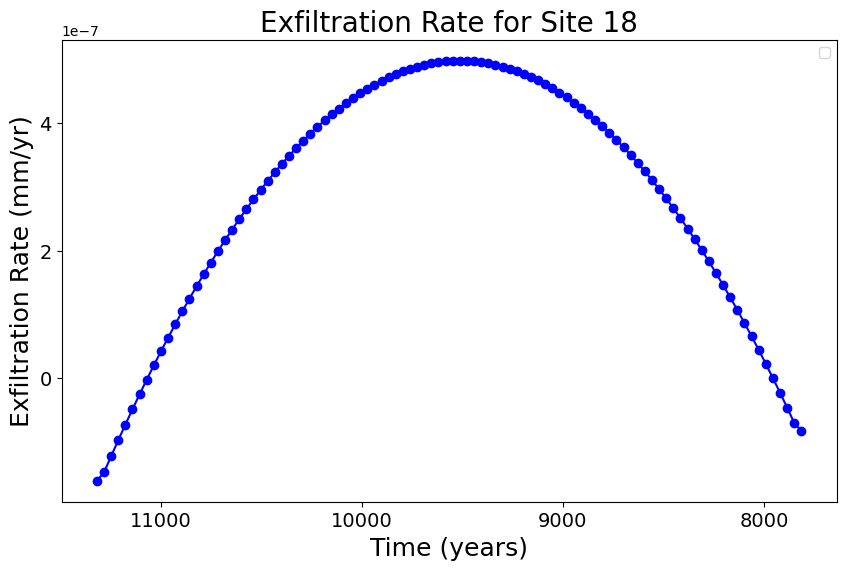

In [72]:
# Constants
year = 3600 * 24 * 365  # seconds in a year
rhoi = 920  # density of glacier ice (kg/m3)
rhow = 1000  # density of water (kg/m3)
g = 9.81  # acceleration due to gravity (m/s2)
mu_w = 1e-3  # viscosity of water (Pa*s)
perm = 1e-13  # permeability (m^2)
K_t = perm * rhow * g / mu_w  # hydraulic conductivity (m/s)
S = 1e-6  # sediment specific storage capacity (m-1)
xi = 0.2  # Skempton's constant (dimensionless)
deltat = (site_data['Age'].max() - site_data['Age'].min()) * year  # time increment based on the site's age range

# Calculate dhdt (rate of change of ice thickness)
dhdt = np.gradient(site_data['Thickness'], site_data['Age'] * year)

# Calculate the exfiltration rate for the selected site
exfil_analytic = 2 * (1 - xi) * (rhoi / rhow) * dhdt * (K_t * S * deltat / np.pi) ** 0.5
exfil_value = exfil_analytic.mean() * year  # Convert to mm/yr

# Plot the exfiltration rate over time
plt.figure(figsize=(10, 6))
plt.plot(site_data['Age'], exfil_analytic * 1000, 'o-', color='blue')
plt.xlabel('Time (years)', fontsize=18)  # Increase the font size
plt.ylabel('Exfiltration Rate (mm/yr)', fontsize=18)  # Increase the font size
plt.title(f'Exfiltration Rate for Site {site}', fontsize=20)  # Increase the font size
plt.gca().invert_xaxis()  # Invert x-axis so that time decreases to the right

# Customize ticks
plt.xticks(fontsize=14)  # Set x-axis tick font size
plt.yticks(fontsize=14)  # Set y-axis tick font size

# Reduce the number of ticks
plt.locator_params(axis='x', nbins=5)  # Fewer ticks on the x-axis
plt.locator_params(axis='y', nbins=5)  # Fewer ticks on the y-axis

plt.legend()
plt.show()

In [73]:
exfil_value

0.008906445097866846

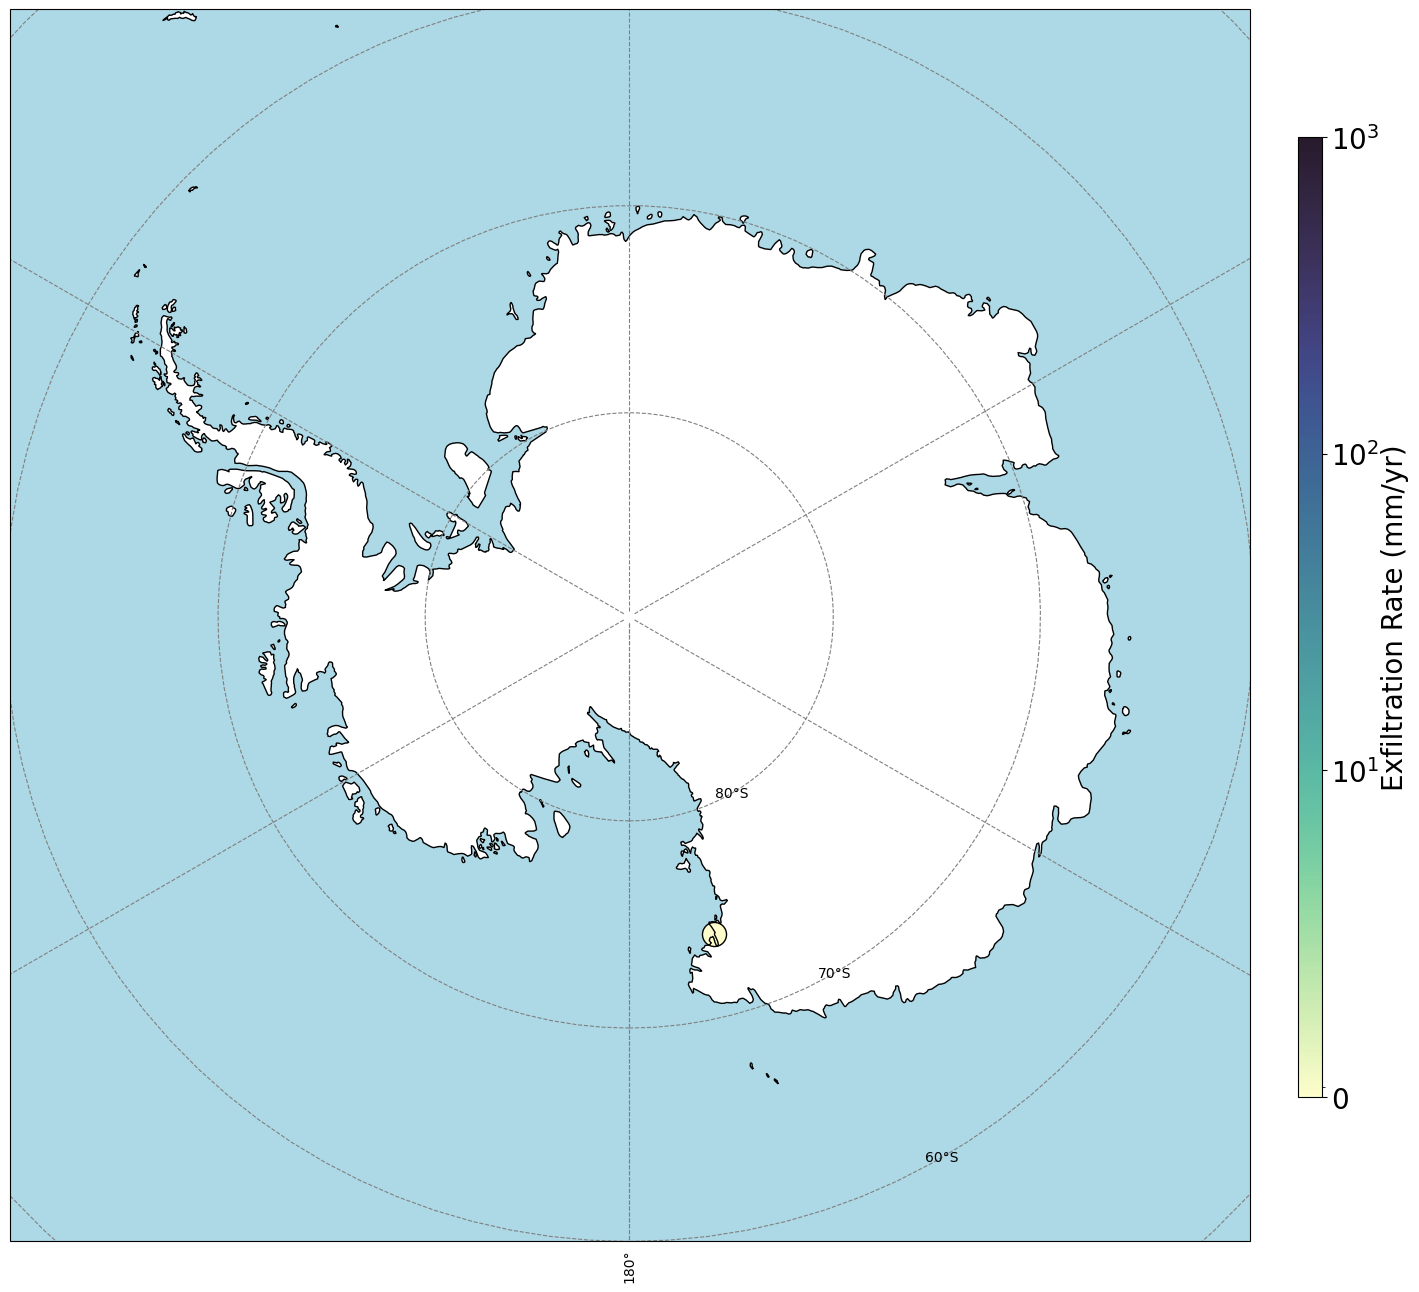

In [74]:
import cartopy.feature as cfeature

# Define the colormap and norm for scaling
cmap = cmocean.cm.deep  

# Custom norm to handle 0 and log scaling from 10^0 to 10^3
class CustomSymLogNorm(colors.SymLogNorm):
    def __init__(self, linthresh=1, linscale=0.03, vmin=0, vmax=1e3):
        super().__init__(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax)

norm = CustomSymLogNorm(linthresh=1, linscale=0.03, vmin=0, vmax=1e3)
# Define the projection for the plot
projection = ccrs.SouthPolarStereo()

# Create a new figure with a size of 16x16 inches for the plot
fig = plt.figure(figsize=(16, 16))

# Add a subplot to the figure using the specified projection
ax = plt.subplot(1, 1, 1, projection=projection)

# Add land and ocean features to show the full continent
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot a marker at the site's location with a color corresponding to the exfiltration rate
sc = ax.scatter(site_lon, site_lat, c=exfil_value, cmap=cmap, norm=norm,
                s=300, marker='o', edgecolor='black', transform=ccrs.PlateCarree())

# Add gridlines to the plot with labels
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
gl.top_labels = False
gl.right_labels = False

# Set the extent to cover the entire Antarctic continent
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Create an additional axis on the right side of the figure to hold the colorbar.
cax = plt.axes([0.93, 0.2, 0.015, 0.6])

# Add the colorbar to the plot, associating it with the marker's color.
ticks = [0, 10, 100, 1000]  # More ticks for finer gradation
cb = plt.colorbar(sc, cax=cax, orientation='vertical', ticks=ticks)

cb.ax.tick_params(axis='both', which='major', labelsize=20)

# Add a label to the colorbar, specifying that it represents the "Exfiltration Rate (mm/yr)".
cb.ax.set_ylabel('Exfiltration Rate (mm/yr)', fontsize=20,labelpad=1)

# Save the plot as a PNG file
plt.savefig('exfiltration_rate_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

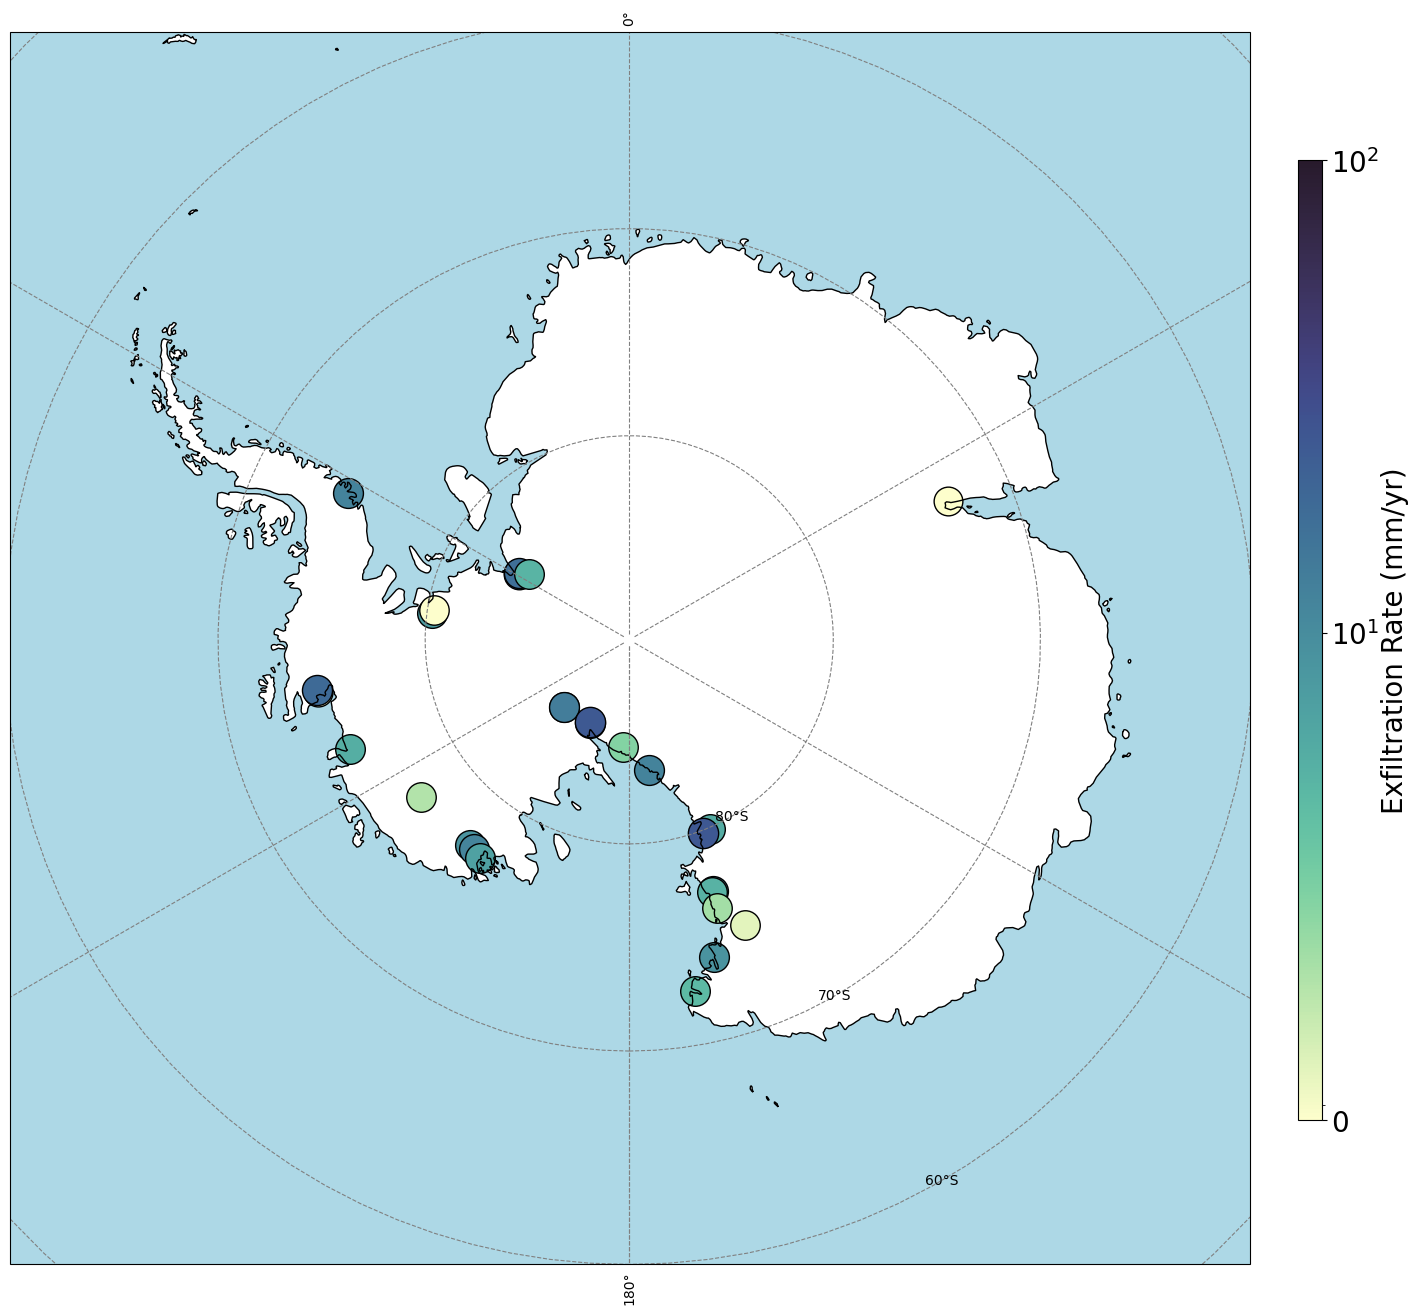

In [77]:
# Define the colormap and norm for scaling
cmap = cmocean.cm.deep  

# Custom norm to handle 0 and log scaling from 10^0 to 10^3
class CustomSymLogNorm(colors.SymLogNorm):
    def __init__(self, linthresh=1, linscale=0.03, vmin=0, vmax=1e2):
        super().__init__(linthresh=linthresh, linscale=linscale, vmin=vmin, vmax=vmax)

norm = CustomSymLogNorm(linthresh=1, linscale=0.03, vmin=0, vmax=1e2)

# Define the projection for the plot
projection = ccrs.SouthPolarStereo()

# Create a new figure with a size of 16x16 inches for the plot
fig = plt.figure(figsize=(16, 16))

# Add a subplot to the figure using the specified projection
ax = plt.subplot(1, 1, 1, projection=projection)

# Add land and ocean features to show the full continent
ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Define the sites to exclude
exclude_sites = []

# Loop through all unique sites and plot each one
for site in interpolated_df['Site'].unique():
    if site in exclude_sites:
        continue  # Skip the sites we want to exclude

    site_data = interpolated_df[interpolated_df['Site'] == site]
    
    # Extract latitude and longitude
    site_lat = site_data['Latm'].values[0]
    site_lon = site_data['Lonm'].values[0]
    
    # Calculate dhdt (rate of change of ice thickness)
    dhdt = np.gradient(site_data['Thickness'], site_data['Age'] * year)
    
    # Calculate the exfiltration rate for the site
    exfil_analytic = 2 * (1 - xi) * (rhoi / rhow) * dhdt * (K_t * S * deltat / np.pi) ** 0.5
    exfil_value = exfil_analytic.mean() * 1000 * year  # Convert to mm/yr
    
    # Scale the marker size based on the exfiltration rate
    marker_size = 450 + (exfil_value / 100) * 100  # Adjust the scaling factor as needed
    
    # Plot the site marker with a color corresponding to the exfiltration rate
    sc = ax.scatter(site_lon, site_lat, c=exfil_value, cmap=cmap, norm=norm,
                    s=marker_size, marker='o', edgecolor='black', transform=ccrs.PlateCarree())

# Add gridlines to the plot with labels
gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray')
gl.top_labels = True 
gl.right_labels = True

# Set the extent to cover the entire Antarctic continent
ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# Create an additional axis on the right side of the figure to hold the colorbar.
cax = plt.axes([0.93, 0.2, 0.015, 0.6])

# Add the colorbar to the plot, associating it with the marker's color.
ticks = [0, 10, 100]  # More ticks for finer gradation
cb = plt.colorbar(sc, cax=cax, orientation='vertical', ticks=ticks)

cb.ax.tick_params(axis='both', which='major', labelsize=20)

# Add a label to the colorbar, specifying that it represents the "Exfiltration Rate (mm/yr)".
cb.ax.set_ylabel('Exfiltration Rate (mm/yr)', fontsize=20,labelpad=1)

# Save the plot as a PNG file
plt.savefig('exfiltration_rate_map.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



In [76]:
# Print calculated exfiltration values for each site 

# Initialize an empty list to store exfiltration values for each site
exfiltration_results = []

# Loop through all unique sites to calculate and store exfiltration rates
for site in interpolated_df['Site'].unique():
    site_data = interpolated_df[interpolated_df['Site'] == site]
    
    # Calculate dhdt (rate of change of ice thickness)
    dhdt = np.gradient(site_data['Thickness'], site_data['Age'] * year)
    
    # Calculate the exfiltration rate for the site
    exfil_analytic = 2 * (1 - xi) * (rhoi / rhow) * dhdt * (K_t * S * deltat / np.pi) ** 0.5
    exfil_value = exfil_analytic.mean() * 1000 * year  # Convert to mm/yr
    
    # Store the results in a dictionary
    exfiltration_results.append({
        'Site': site,
        'Latitude': site_data['Latm'].values[0],
        'Longitude': site_data['Lonm'].values[0],
        'Exfiltration Rate (mm/yr)': exfil_value
    })

# Convert the results to a DataFrame for easier viewing
exfiltration_df = pd.DataFrame(exfiltration_results)

# Print the exfiltration values for each site
print(exfiltration_df)

    Site   Latitude   Longitude  Exfiltration Rate (mm/yr)
0      1 -83.687038  -59.022073                  34.732035
1      2 -83.691864  -58.701025                  17.239731
2      3 -80.263955  -82.145070                   7.469532
3      4 -77.311186 -142.111414                   8.804249
4      5 -77.263914 -143.332900                  11.766161
5      6 -77.073576 -145.602922                   6.827724
6      7 -85.399455 -136.212298                   5.043840
7      8 -85.423334 -135.903359                  13.287178
8      9 -80.327539  -81.412245                  -1.606983
9     10 -75.375232 -111.299720                   5.393388
10    11 -74.591938  -99.449300                 -16.830952
11    12 -74.552285  -99.195232                  18.789190
12    13 -79.912045  156.836553                   5.561736
13    14 -79.884968  159.143763                  25.390222
14    15 -73.037487   66.439262                 -22.145945
15    16 -77.215466 -127.056014                   1.7914

## Only execute the next two cells to calculate sums (i.e., dont execute if you want to correctly make plots below)

In [24]:
# Open the zip file "iceShelves.zip" in read mode and extract its contents to the current directory.
# This step is necessary to access the ice shelf boundaries and other related data stored in the zip file.
#with zipfile.ZipFile("iceShelves.zip", "r") as zip_ref:
   # zip_ref.extractall(".")

# Load the ice shelf mask from the extracted "iceShelves.geojson" file using GeoPandas.
# This file contains the geometries of different ice shelves.
#iceshelvesmask = gpd.read_file('iceShelves.geojson')

# Convert the coordinate reference system (CRS) of the ice shelves mask to EPSG 3031, which is a polar stereographic projection.
# This projection is commonly used for polar regions, particularly in Antarctica.
#icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})

# Clip the original raster data (da) to the geometry of the West Antarctic Ice Sheet (WAIS),
# which is the 5th entry (index 4) in the ice shelves mask GeoDataFrame.
# This step extracts the portion of the raster data corresponding to the WAIS.
#da_wais = da.rio.clip(icems.loc[[4], 'geometry'])

# Extract the thinning rate (dhdt) for the WAIS from the clipped raster data.
# The thinning rate data is assumed to be in the first layer (band 0) of the raster.
#dhdt_wais = da_wais.variable.data[0]

# Clip the original raster data (da) to the geometry of the Thwaites Glacier,
# which is the 27th entry (index 26) in the ice shelves mask GeoDataFrame.
#da_thwaites = da.rio.clip(icems.loc[[26], 'geometry'])

# Extract the thinning rate (dhdt) for the Thwaites Glacier from the clipped raster data.
#dhdt_thwaites = da_thwaites.variable.data[0]

# Clip the original raster data (da) to the geometry of the Pine Island Glacier (PIG),
# which is the 28th entry (index 27) in the ice shelves mask GeoDataFrame.
#da_pig = da.rio.clip(icems.loc[[27], 'geometry'])

# Extract the thinning rate (dhdt) for the Pine Island Glacier from the clipped raster data.
#dhdt_pig = da_pig.variable.data[0]


In [ ]:
# Calculate the analytical exfiltration rate for the West Antarctic Ice Sheet (WAIS) using the thinning rate (dhdt_wais),
# thermal conductivity (K_t), a scaling factor (S), and time step (deltat).
# The formula includes a density ratio (rhoi/rhow) and a correction factor (xi).
# The result is scaled by -2 and represents the exfiltration rate.
#exfil_analytic_wais = -2 * (1 - xi) * (rhoi / rhow) * dhdt_wais * (K_t * S * deltat / np.pi) ** 0.5

# Calculate the analytical exfiltration rate for Thwaites Glacier using the same formula as above but applied to dhdt_thwaites.
#exfil_analytic_thwaites = -2 * (1 - xi) * (rhoi / rhow) * dhdt_thwaites * (K_t * S * deltat / np.pi) ** 0.5

# Calculate the analytical exfiltration rate for Pine Island Glacier (PIG) using the same formula as above but applied to dhdt_pig.
#exfil_analytic_pig = -2 * (1 - xi) * (rhoi / rhow) * dhdt_pig * (K_t * S * deltat / np.pi) ** 0.5

# Calculate the sum of exfiltration over the entire area, considering only regions where thinning occurs (dhdt < 0).
# First, create a copy of the full exfiltration data (exfil_analytic).
#exfil_analytic_justex = exfil_analytic

# Set regions where dhdt is positive (indicating thickening) to NaN, as we are only interested in exfiltration.
#exfil_analytic_justex[dhdt > 0] = np.nan

# Sum the exfiltration over the entire area, multiplying by the grid cell area (5 km x 5 km) and converting units.
# The result is in gigatons per year (Gt/yr).
#exfil_aa = np.nansum(exfil_analytic_justex * (5e3**2)) * 1000 / 1e12

# Repeat the same process for the WAIS:
#exfil_analytic_justex_wais = exfil_analytic_wais
#exfil_analytic_justex_wais[dhdt_wais > 0] = np.nan
#exfil_wais = np.nansum(exfil_analytic_justex_wais * (5e3**2)) * 1000 / 1e12

# Repeat the same process for Thwaites Glacier:
#exfil_analytic_justex_thwaites = exfil_analytic_thwaites
#exfil_analytic_justex_thwaites[dhdt_thwaites > 0] = np.nan
#exfil_thwaites = np.nansum(exfil_analytic_justex_thwaites * (5e3**2)) * 1000 / 1e12

# Repeat the same process for Pine Island Glacier (PIG):
#exfil_analytic_justex_pig = exfil_analytic_pig
#exfil_analytic_justex_pig[dhdt_pig > 0] = np.nan
#exfil_pig = np.nansum(exfil_analytic_justex_pig * (5e3**2)) * 1000 / 1e12

# Calculate the total exfiltration for the Amundsen Sea Embayment (ASE) region by summing the contributions
# from Thwaites Glacier and Pine Island Glacier.
#exfil_ase = exfil_thwaites + exfil_pig


# Fraction of subglacial water budget (Pattyn 2010) - Figure 4

In [ ]:
# Load the MATLAB file 'Pattyn2010_basalmelt_mean_smithgrid.mat' using SciPy's loadmat function.
# The 'struct_as_record=False' argument ensures that MATLAB structs are loaded as simple Python dictionaries.
#mat_contents = sio.loadmat('Pattyn2010_basalmelt_mean_smithgrid.mat', struct_as_record=False)

# Extract the basal melt rate data from the loaded MATLAB file.
# The data is stored in the variable 'basalmelt_smithgrid' within the MATLAB file.
#bmr = mat_contents['basalmelt_smithgrid']

# Calculate the fraction of exfiltration relative to the sum of the basal melt rate and the exfiltration rate.
# This gives an idea of how significant exfiltration is compared to basal melting.
#exfilfrac_basalmelt = exfil_analytic / (bmr + exfil_analytic)

# (Optional) The following lines create a meshgrid for the Pattyn et al. (2010) data, spanning the domain from -2,800,000 to 2,805,000 meters
# with a resolution of 5,000 meters. This meshgrid could be used for further analysis or plotting of the Pattyn data.
# x_pattyn = np.arange(-2800000, 2805000, 5000)
# xx_pattyn, yy_pattyn = np.meshgrid(x_pattyn, x_pattyn)


In [ ]:
# Define the map projection using the South Polar Stereographic projection, suitable for visualizing polar regions.
#projection = ccrs.SouthPolarStereo()

# Create a new figure with a size of 16x16 inches for the plot.
#fig = plt.figure(figsize=(16, 16))

# Add a subplot to the figure using the specified projection.
# The subplot occupies the entire figure (1 row, 1 column, 1 subplot).
#ax = plt.subplot(1, 1, 1, projection=projection)

# Create a pseudocolor mesh plot (pcolormesh) on the axes using the meshgrid coordinates (xx, yy) and the basal melt rate data (bmr).
# The data is scaled by 1000 to convert it to millimeters per year (mm/yr).
# The colormap 'cmocean.cm.dense' is used, which is designed for visualizing dense datasets like ice or water content.
# The color normalization is set to logarithmic scaling (LogNorm) to handle a wide range of values,
# with the minimum value set to 1 mm/yr and the maximum value set to 100 mm/yr.
#p1 = ax.pcolormesh(xx, yy, 1000 * bmr, cmap=cmocean.cm.dense, norm=colors.LogNorm(vmin=1, vmax=100))

# Set the extent of the plot slightly larger than the minimum and maximum x and y values, scaled by 1.05.
# This ensures that the plotted area fully covers the region of interest.
#ax.set_extent([min(x) * 1.05, max(x) * 1.05, min(y) * 1.05, max(y) * 1.05], crs=ccrs.SouthPolarStereo())

# Add coastlines to the plot to provide geographic context.
#ax.coastlines()

# Add gridlines to the plot and enable the drawing of labels on the gridlines.
3ax.gridlines(draw_labels=True)

# Create an additional axis on the right side of the figure to hold the colorbar.
# The position of the colorbar is specified by [left, bottom, width, height].
#cax = plt.axes([0.95, 0.25, 0.015, 0.5])

# Add the colorbar to the plot, associating it with the pcolormesh object (p1).
# The colorbar is oriented vertically, with tick marks at -100, -10, 0, 10, and 100.
#cb = plt.colorbar(p1, cax=cax, orientation='vertical', ticks=[-100, -10, 0, 10, 100])

# Set the label for the colorbar to "Basal Melt Rate (mm/yr)" with a font size of 24,
# indicating that the colorbar represents the basal melt rate in millimeters per year.
#cb.ax.set_ylabel('Basal Melt Rate (mm/yr)', fontsize=24)


In [ ]:
# Define the map projection using the South Polar Stereographic projection, ideal for visualizing polar regions.
#projection = ccrs.SouthPolarStereo()

# Create a new figure with a size of 16x16 inches for the plot.
#fig = plt.figure(figsize=(16, 16))

# Add a subplot to the figure using the specified projection.
# The subplot will occupy the entire figure (1 row, 1 column, 1 subplot).
#ax = plt.subplot(1, 1, 1, projection=projection)

# Create a pseudocolor mesh plot (pcolormesh) on the axes using the meshgrid coordinates (xx, yy) and the exfiltration fraction of basal melt (exfilfrac_basalmelt).
# The colormap 'PRGn' is used, which provides a diverging color scheme that is effective for displaying data with a natural midpoint (e.g., 0).
# The color range is set with vmin=-1 and vmax=1 to cover the entire range of the exfiltration fraction.
#p1 = ax.pcolormesh(xx, yy, exfilfrac_basalmelt, cmap='PRGn', vmin=-1, vmax=1)

# Set the extent of the plot slightly larger than the minimum and maximum x and y values, scaled by 1.05.
# This ensures that the plotted area fully covers the region of interest.
#ax.set_extent([min(x) * 1.05, max(x) * 1.05, min(y) * 1.05, max(y) * 1.05], crs=ccrs.SouthPolarStereo())

# Add coastlines to the plot to provide geographic context.
#ax.coastlines()

# Add gridlines to the plot and enable the drawing of labels on the gridlines.
#ax.gridlines(draw_labels=True)

# Create an additional axis on the right side of the figure to hold the colorbar.
# The position of the colorbar is specified by [left, bottom, width, height].
#cax = plt.axes([0.95, 0.2, 0.015, 0.6])

# Add the colorbar to the plot, associating it with the pcolormesh object (p1).
# The colorbar is oriented vertically.
#cb = plt.colorbar(p1, cax=cax, orientation='vertical')

# Set the font size for the tick labels on the colorbar.
#cb.ax.tick_params(axis='both', which='major', labelsize=20)

# Add a label to the colorbar, specifying that it represents the "Exfiltration rate fraction of total water budget".
# The font size for the label is set to 24.
#cb.ax.set_ylabel('Exfiltration rate fraction of total water budget', fontsize=24)

# (Optional) Save the figure as a PNG file with the specified filename.
# The 'bbox_inches' option ensures that the entire plot, including labels, is saved.
# plt.savefig('IceSat2_thinningexfil_perm1e-13_justexfilfrac_v1.png', bbox_inches='tight')


# All panels together now

In [ ]:
# All panels from above just put together now 
#projection=ccrs.SouthPolarStereo()
#fig = plt.figure(figsize=(16, 16))
#ax1 = plt.subplot(3, 2, 1, projection=projection)
#p1 = ax1.pcolormesh(xx, yy, 1000*exfil_analytic, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
#ax1.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax1.coastlines()
#ax1.gridlines(draw_labels=True)
#ax1.text(-0.07, 0.55, '$k=10^{-13}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax1.transAxes, fontsize=24)
#ax1.text(0.05, 0.9, '(a)', va='bottom', ha='center',transform=ax1.transAxes, fontsize=20)

#ax3 = plt.subplot(3, 2, 3, projection=projection)
#p3 = ax3.pcolormesh(xx, yy, 1000*exfil_analytic/10, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
#ax3.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax3.coastlines()
#ax3.gridlines(draw_labels=True)
#ax3.text(-0.07, 0.55, '$k=10^{-15}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax3.transAxes, fontsize=24)
#ax3.text(0.05, 0.9, '(b)', va='bottom', ha='center',transform=ax3.transAxes, fontsize=20)

#ax5 = plt.subplot(3, 2, 5, projection=projection)
#p5 = ax5.pcolormesh(xx, yy, 1000*exfil_analytic/100, cmap=cmocean.cm.tarn, norm=colors.SymLogNorm(linthresh=1.0, linscale=0.03,
                                              vmin=-100, vmax=100) )
#ax5.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax5.coastlines()
#ax5.gridlines(draw_labels=True)
#ax5.text(-0.07, 0.55, '$k=10^{-17}$ m$^2$', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax5.transAxes, fontsize=24)
#ax5.text(0.05, 0.9, '(c)', va='bottom', ha='center',transform=ax5.transAxes, fontsize=20)

#cax1 = plt.axes([0.485, 0.135, 0.015, 0.73])
#cb1 = plt.colorbar(p1, cax=cax1, orientation='vertical',ticks=[-100, -10, 0, 10, 100])
#cb1.ax.set_ylabel('Exfiltration Rate (mm/yr)',fontsize=18)

#ax2 = plt.subplot(3, 2, 2, projection=projection)
#p2 = ax2.pcolormesh(xx, yy, exfilfrac_basalmelt, cmap='PRGn',vmin=-1,vmax=1)
#ax2.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax2.coastlines()
#ax2.gridlines(draw_labels=True)
#ax2.text(0.05, 0.9, '(d)', va='bottom', ha='center',transform=ax2.transAxes, fontsize=20)

#ax4 = plt.subplot(3, 2, 4, projection=projection)
#p4 = ax4.pcolormesh(xx, yy, exfilfrac_basalmelt/10, cmap='PRGn',vmin=-1,vmax=1)
#ax4.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax4.coastlines()
#ax4.gridlines(draw_labels=True)
#ax4.text(0.05, 0.9, '(e)', va='bottom', ha='center',transform=ax4.transAxes, fontsize=20)

#ax6 = plt.subplot(3, 2, 6, projection=projection)
#p6 = ax6.pcolormesh(xx, yy, exfilfrac_basalmelt/100, cmap='PRGn',vmin=-1,vmax=1)
#ax6.set_extent([min(x)*1.05, max(x)*1.05, min(y)*1.05, max(y)*1.05], crs=ccrs.SouthPolarStereo()) 
#ax6.coastlines()
#ax6.gridlines(draw_labels=True)
#ax6.text(0.05, 0.9, '(f)', va='bottom', ha='center',transform=ax6.transAxes, fontsize=20)

#cax2 = plt.axes([0.90, 0.135, 0.015, 0.73])
#cb2 = plt.colorbar(p2, cax=cax2, orientation='vertical')
#cb2.ax.set_ylabel('Exfiltration rate fraction of total water budget',fontsize=18);

#plt.savefig('IceSat2_thinningexfil_allperms_v6_alt.png', bbox_inches='tight', dpi =200)

# Calculate Sums (skip to here from other summing cells above)

In [ ]:
# Create a copy of the original data array (da) and assign it to da2.
# Replace the data in the first layer (band 0) of da2 with the basal melt rate data (bmr).
#da2 = da
#da2.variable.data[0] = bmr

# Clip the modified data (da2) to the geometry of the West Antarctic Ice Sheet (WAIS),
# which is the 5th entry (index 4) in the ice shelves mask GeoDataFrame (icems).
# This step extracts the portion of the basal melt rate data corresponding to the WAIS.
#da2_wais = da2.rio.clip(icems.loc[[4], 'geometry'])

# Extract the basal melt rate (bmr) for the WAIS from the clipped data.
#bmr_wais = da2_wais.variable.data[0]

# Create another copy of the original data array (da) and assign it to da3.
# Again, replace the data in the first layer (band 0) with the basal melt rate data (bmr).
#da3 = da
#da3.variable.data[0] = bmr

# Clip the modified data (da3) to the geometry of the Thwaites Glacier,
# which is the 27th entry (index 26) in the ice shelves mask GeoDataFrame (icems).
#da3_thwaites = da3.rio.clip(icems.loc[[26], 'geometry'])

# Extract the basal melt rate (bmr) for the Thwaites Glacier from the clipped data.
#bmr_thwaites = da3_thwaites.variable.data[0]

# Create another copy of the original data array (da) and assign it to da4.
# Replace the data in the first layer (band 0) with the basal melt rate data (bmr).
#da4 = da
#da4.variable.data[0] = bmr

# Clip the modified data (da4) to the geometry of the Pine Island Glacier (PIG),
# which is the 28th entry (index 27) in the ice shelves mask GeoDataFrame (icems).
#da4_pig = da4.rio.clip(icems.loc[[27], 'geometry'])

# Extract the basal melt rate (bmr) for the Pine Island Glacier (PIG) from the clipped data.
#bmr_pig = da4_pig.variable.data[0]


In [ ]:
# Calculate the total basal melt rate (bmrtotal_aa) across the entire area.
# The basal melt rate (bmr) is summed, multiplying by the area of each grid cell (5 km x 5 km) to get the total melt in square meters.
# The result is then scaled by 1000 to convert from meters to millimeters, and by 1e12 to convert from cubic meters to gigatons.
# The final result is the total basal melt rate in gigatons per year (Gt/yr).
#bmrtotal_aa = np.nansum(bmr * (5e3**2)) * 1000 / 1e12

# Calculate the fraction of the total water budget that is due to exfiltration.
# This is done by dividing the total exfiltration rate (exfil_aa) by the sum of the total basal melt rate and the exfiltration rate.
# The result is a ratio that indicates how much of the total water loss is due to exfiltration.
#exfil_aa / (bmrtotal_aa + exfil_aa)


In [ ]:
# Same as above
#bmrtotal_wais = np.nansum(bmr_wais*(5e3**2))*1000/1e12

#exfil_wais/(bmrtotal_wais+exfil_wais)
#exfil_wais

In [ ]:
# Same as above
#bmrtotal_thwaites = np.nansum(bmr_thwaites*(5e3**2))*1000/1e12

#exfil_thwaites/(bmrtotal_thwaites+exfil_thwaites)

In [ ]:
# Same as above
#bmrtotal_pig = np.nansum(bmr_pig*(5e3**2))*1000/1e12

#exfil_pig/(bmrtotal_pig+exfil_pig)

In [ ]:
# Same as above
#exfil_ase/(bmrtotal_pig+bmrtotal_thwaites+exfil_ase)
#exfil_ase